--2020-05-29 11:18:47--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2.7’

shape_predictor_5_f 100%[===================>]   5.44M  3.31MB/s    in 1.6s    

2020-05-29 11:18:49 (3.31 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2.7’ saved [5706710/5706710]



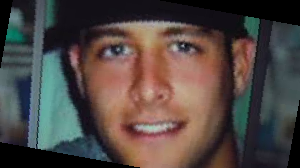

In [0]:
import cv2
import numpy as np
from PIL import Image
import dlib
from google.colab.patches import cv2_imshow  #display using cv2_imshow(<image>)
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
#!bunzip2 "shape_predictor_5_face_landmarks.dat.bz2"


detector = dlib.get_frontal_face_detector()


predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

from google.colab import files

#uploaded =  files.upload()

img = cv2.imread('images.jfif')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 0)


if len(rects) > 0:
    for rect in rects:
        x = rect.left()
        y = rect.top()
        w = rect.right()
        h = rect.bottom()
        shape = predictor(gray, rect)


def shape_to_normal(shape):
    shape_normal = []
    for i in range(0, 5):
        shape_normal.append((i, (shape.part(i).x, shape.part(i).y)))
    return shape_normal

def get_eyes_nose_dlib(shape):
    nose = shape[4][1]
    left_eye_x = int(shape[3][1][0] + shape[2][1][0]) // 2
    left_eye_y = int(shape[3][1][1] + shape[2][1][1]) // 2
    right_eyes_x = int(shape[1][1][0] + shape[0][1][0]) // 2
    right_eyes_y = int(shape[1][1][1] + shape[0][1][1]) // 2
    return nose, (left_eye_x, left_eye_y), (right_eyes_x, right_eyes_y)        

shap = shape_to_normal(shape)
nose, left_eye, right_eye = get_eyes_nose_dlib(shap)
 
center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    
center_pred = (int((x + w) / 2), int((y + h) / 2))

def distance(a, b):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

length_line1 = distance(center_of_forehead, nose)
length_line2 = distance(center_pred, nose)
length_line3 = distance(center_pred, center_of_forehead)




def cosine_formula(length_line1, length_line2, length_line3):
    cos_a = -(length_line3 ** 2 - length_line2 ** 2 - length_line1 ** 2) / (2 * length_line2 * length_line1)
    return cos_a

cos_a = cosine_formula(length_line1, length_line2, length_line3)
angle = np.arccos(cos_a)

def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy


def is_between(point1, point2, point3, extra_point):
    c1 = (point2[0] - point1[0]) * (extra_point[1] - point1[1]) - (point2[1] - point1[1]) * (extra_point[0] - point1[0])
    c2 = (point3[0] - point2[0]) * (extra_point[1] - point2[1]) - (point3[1] - point2[1]) * (extra_point[0] - point2[0])
    c3 = (point1[0] - point3[0]) * (extra_point[1] - point3[1]) - (point1[1] - point3[1]) * (extra_point[0] - point3[0])
    if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
        return True
    else:
        return False
   
rotated_point = rotate_point(nose, center_of_forehead, angle)

rotated_point = (int(rotated_point[0]), int(rotated_point[1]))

if is_between(nose, center_of_forehead, center_pred, rotated_point):
    angle = np.degrees(angle)
else:
    angle = np.degrees(-angle)

img = Image.fromarray(img)
    
img = np.array(img.rotate(angle))

cv2_imshow(img)